# BUILDING A DEFUALT DETECTION MODEL

---



## Table of Contents
1. Problem Description (Brief Write Up)
2. Exploratory Data Analysis (EDA)
3. Data Pre-processing
4. Model Selection
5. Evaluation
6. Discussion and Possible Improvements

## 1. Problem Description

The goal of this project is to predict a binary target feature (default or not) valued 0 (= not default) or 1 (= default). This project will cover the entire data science pipeline, from data analysis to model evaluation. We will be trying several models to predict default status, and choosing the most appropriate one at the end. 

The data set we will be working on contains payment information of 30,000 credit card holders obtained from a bank in Taiwan, and each data sample is described by 23 feature attributes and the binary target feature (default or not).

The 23 explanatory attributes and their explanations (from the data provider) are as follows:

### X1 - X5: Indivual attributes of customer

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 

X2: Gender (1 = male; 2 = female). 

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 

X4: Marital status (1 = married; 2 = single; 3 = others). 

X5: Age (year). 

### X6 - X11: Repayment history from April to Septemeber 2005
The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months, . . . 8 = payment delay for eight months; 9 = payment delay for nine months and above.


X6 = the repayment status in September, 2005

X7 = the repayment status in August, 2005

X8 = the repayment status in July, 2005

X9 = the repayment status in June, 2005

X10 = the repayment status in May, 2005

X11 = the repayment status in April, 2005. 

### X12 - X17: Amount of bill statement (NT dollar) from April to September 2005

X12 = amount of bill statement in September, 2005; 

X13 = amount of bill statement in August, 2005

. . .

X17 = amount of bill statement in April, 2005. 

### X18 - X23: Amount of previous payment (NT dollar)
X18 = amount paid in September, 2005

X19 = amount paid in August, 2005

. . .

X23 = amount paid in April, 2005. 


## EDA

In this section we will explore the data set, its shape and its features to get an idea of the data.

### Importing packages and the dataset

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np

In [4]:
url = 'https://raw.githubusercontent.com/reonho/bt2101disrudy/master/card.csv'
df = pd.read_csv(url,  header = 1, index_col = 0)
# Dataset is now stored in a Pandas Dataframe

In [5]:
#rename the target variable to "Y" for convenience
df["Y"] = df["default payment next month"] 
df = df.drop("default payment next month", axis = 1)
df0 = df #backup of df
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
size = df.shape
print("Data has {} Columns and {} Rows".format(size[1], size[0]))

Data has 24 Columns and 30000 Rows


In [7]:
#check for null values
df.isnull().any().sum() 

0

From the above analyses, we observe that:
1. The data indeed has 30000 rows and 24 columns
2. There are no null values

We will now explore the features more in depth.

### Exploring the features

**1) Exploring target attribute:**


defaults : 22.12 %
non defaults : 77.88000000000001 %


Text(0, 0.5, 'Frequency')

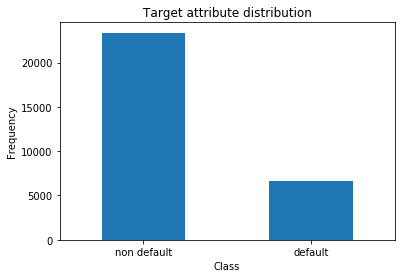

In [8]:
All = df.shape[0]
default = df[df['Y'] == 1]
nondefault = df[df['Y'] == 0]

x = len(default)/All
y = len(nondefault)/All

print('defaults :',x*100,'%')
print('non defaults :',y*100,'%')

# plotting target attribute against frequency
labels = ['non default','default']
classes = pd.value_counts(df['Y'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Target attribute distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

**2) Exploring categorical attributes**

Categorical attributes are:
- Sex
- Education
- Marriage

In [9]:
print(df["SEX"].value_counts().apply(lambda r: r/All*100))
print("--------------------------------------------------------")
print(df["EDUCATION"].value_counts().apply(lambda r: r/All*100))
print("--------------------------------------------------------")
print(df["MARRIAGE"].value_counts().apply(lambda r: r/All*100))

2    60.373333
1    39.626667
Name: SEX, dtype: float64
--------------------------------------------------------
2    46.766667
1    35.283333
3    16.390000
5     0.933333
4     0.410000
6     0.170000
0     0.046667
Name: EDUCATION, dtype: float64
--------------------------------------------------------
2    53.213333
1    45.530000
3     1.076667
0     0.180000
Name: MARRIAGE, dtype: float64


**Findings**

- Categorical variable SEX does not seem to have any missing/extra groups, and it is separated into Male = 1 and Female = 2
- Categorical variable MARRIAGE seems to have unknown group = 0, which could be assumed to be missing data, with other groups being Married = 1, Single = 2, Others = 3
- Categorical variable EDUCATION seems to have unknown group = 0,5,6, with other groups being graduate school = 1, university = 2, high school = 3, others = 4 

In [10]:
#proportion of target attribute (for reference)
print('Total target attributes:')
print('non defaults :',y*100,'%')
print('defaults :',x*100,'%')
print("--------------------------------------------------------")
#analysing default payment with Sex
sex_target = pd.crosstab(df["Y"], df["SEX"]).apply(lambda r: r/r.sum()*100).rename(columns = {1: "Male", 2: "Female"}, index = {0: "non defaults", 1: "defaults"})
print(sex_target)
print("--------------------------------------------------------")
#analysing default payment with education
education_target = pd.crosstab(df["Y"], df["EDUCATION"]).apply(lambda r: r/r.sum()*100).rename(index = {0: "non defaults", 1: "defaults"})
print(education_target)
print("--------------------------------------------------------")
#analysing default payment with marriage
marriage_target = pd.crosstab(df["Y"], df["MARRIAGE"]).apply(lambda r: r/r.sum()*100).rename(columns = {0: "unknown",1: "married", 2: "single", 3: "others"},index = {0: "non defaults", 1: "defaults"})
print(marriage_target)

Total target attributes:
non defaults : 77.88000000000001 %
defaults : 22.12 %
--------------------------------------------------------
SEX                Male     Female
Y                                 
non defaults  75.832773  79.223719
defaults      24.167227  20.776281
--------------------------------------------------------
EDUCATION         0          1          2          3          4          5  \
Y                                                                            
non defaults  100.0  80.765234  76.265146  74.842384  94.308943  93.571429   
defaults        0.0  19.234766  23.734854  25.157616   5.691057   6.428571   

EDUCATION             6  
Y                        
non defaults  84.313725  
defaults      15.686275  
--------------------------------------------------------
MARRIAGE        unknown    married     single     others
Y                                                       
non defaults  90.740741  76.528296  79.071661  73.993808
defaults       9.25925

**Conclusion**

From the analyses above we conclude that

1. The categorical data is noisy - EDUCATION and MARRIAGE contains unexplained/anomalous data.


**3) Analysis of Numerical Attributes**

The numerical attributes are:
   




In [11]:
#printing numerical attributes
pd.DataFrame(df.drop(['SEX', 'EDUCATION', 'MARRIAGE','Y'], axis = 1).columns).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6


In [12]:
df.drop(['SEX', 'EDUCATION', 'MARRIAGE','Y'], axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0
PAY_6,30000.0,-0.291100,1.149988,-2.0,-1.00,0.0,0.00,8.0
BILL_AMT1,30000.0,51223.330900,73635.860576,-165580.0,3558.75,22381.5,67091.00,964511.0
BILL_AMT2,30000.0,49179.075167,71173.768783,-69777.0,2984.75,21200.0,64006.25,983931.0


**Analysis of PAY_0 to PAY_6**

We observe that the minimum value of PAY_0 to PAY_6 is -2. The dataset's author has explained these factors (PAY_0 to PAY_6) as the number of months of payment delay, that is, 1= payment delay of one month; 2= payment delay of two months and so on. 

However, the presence of -2, -1 in these columns indicates that
1. There is anomalous data, OR 
2. The numbers do not strictly correspond to the number of months of payment delay. 

This means we must conduct some data transformation.

According to **(link)**, the numeric value in these attributes shows the past history of a credit card holder, where -2 means: No consumption of credit card, -1 means that holder paid the full balance, and 0 means the use of revolving credit.



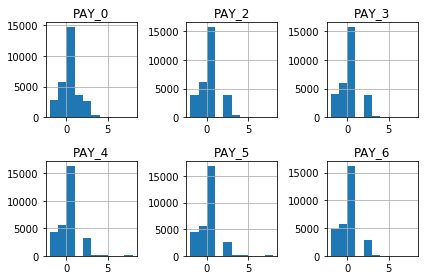

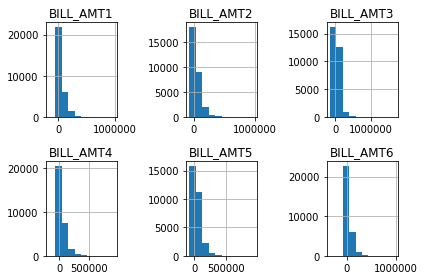

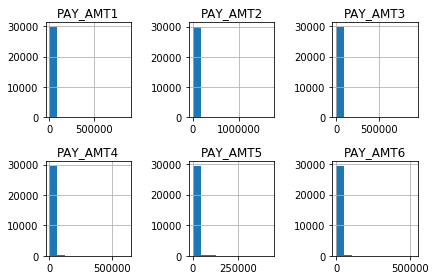

In [13]:
def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=n_bins,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

PAY = df[['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
BILLAMT = df[['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
PAYAMT = df[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

draw_histograms(PAY, PAY.columns, 2, 3, 10)
draw_histograms(BILLAMT, BILLAMT.columns, 2, 3, 10)
draw_histograms(PAYAMT, PAYAMT.columns, 2, 3, 10)

We observe that the "repayment status" attributes are the most highly correlated with the target variable and we would expect them to be more significant in predicting credit default. In fact the later the status (pay_0 is later than pay_6), the more correlated it is.

Now that we have an idea of the features, we will move on to feature selection and data preparation.

## Data Preprocessing

It was previously mentioned that our data had a bit of noise, so we will clean up the data in this part. Additionally, we will conduct some feature selection.
1. Removing Noise - Inconsistencies
2. Dealing with negative values of PAY_0 to PAY_6
3. Outliers
4. One Hot Encoding
5. Train Test Split
6. Feature selection


### Removing Noise
First, we found in our data exploration that education has unknown groups 0, 5 and 6. These will be replaced with Education = Others, which has value 4

In [14]:
df['EDUCATION'].replace([0,5,6], 4, regex=True, inplace=True)
df["EDUCATION"].unique()

array([2, 1, 3, 4])

Similarly, for Marriage

In [15]:
df['MARRIAGE'].replace([0], 3, regex=True, inplace=True)
df["MARRIAGE"].unique()

array([1, 2, 3])

### Separating negative and positive values for PAY_0 to PAY_6

Second, we are going to extract the negative values of PAY_0 to PAY_6 as another categorical feature. This way, PAY_0 to PAY_6 can be thought of purely as the months of delay of payments.

The negative values will form a categorical variable. e.g. negative values of PAY_0 will form the categorical variable S_0.

In [16]:
for i in range(0,7):
    try:
        df["S_" + str(i)] = [x  if x < 1 else 1 for x in df["PAY_" + str(i)]]
    except:
        pass

In [17]:
print('Dummy variables for negative values')
df[["S_0", "S_2", "S_3", "S_4", "S_5", "S_6"]].head()

Dummy variables for negative values


,S_0,S_2,S_3,S_4,S_5,S_6
ID,,,,,,
1,1,1,-1,-1,-2,-2
2,-1,1,0,0,0,1
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,-1,0,-1,0,0,0


In [18]:
#attributes representing positive values
for col in ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]:
    df[col].replace([0,-1,-2], 0, regex=True, inplace=True)

### Outliers
Next, we would like to remove outliers from the continuous variables. Assuming that all the data points are normally distributed, we will consider a point an outlier if it falls outside the 99% interval of a distribution. (Critical value = 2.58) 

In [19]:
from scipy import stats
#we are only concerned with the ordinal data
o = pd.DataFrame(df.drop(['Y','EDUCATION', 'MARRIAGE', "SEX","S_0", "S_2", "S_3", "S_4", "S_5", "S_6","PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"], axis=1))
#rows where the absolute z score of all columns are less than 2.58 (critical value)
rows = (np.abs(stats.zscore(o)) < 2.58).all(axis=1)
df = df[rows]
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,S_0,S_2,S_3,S_4,S_5,S_6
count,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,...,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000
mean,149324.899981,1.608954,1.852734,1.564717,35.006592,0.372109,0.337321,0.324633,0.278224,0.238750,...,2787.425071,2778.830673,2822.285007,0.230177,-0.133587,-0.300438,-0.327300,-0.364412,-0.395999,-0.428158
std,116558.616530,0.487994,0.738572,0.521936,8.832028,0.765730,0.814878,0.811491,0.786314,0.743923,...,4835.081906,4751.263287,5271.198100,0.420954,0.879876,0.883472,0.895264,0.886115,0.877789,0.900723
min,10000.000000,1.000000,1.000000,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,150.000000,82.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,120000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1200.000000,1218.000000,1143.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,210000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3118.000000,3140.000000,3069.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,500000.000000,2.000000,4.000000,3.000000,59.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,45171.000000,44197.000000,51000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Scaling
The models used subsequently may have difficulty converging before the maximum number of iterations allowed
is reached if the data is not normalized. Additionaly, Multi-layer Perceptron is sensitive to feature scaling, so we will use StandardScaler for standardization. We only want to scale the numerical factors.

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols = df.drop(['Y','EDUCATION', 'MARRIAGE', "SEX","S_0", "S_2", "S_3", "S_4", "S_5", "S_6","PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"], axis =1)
df1 = df.copy()
df1[cols.columns] = scaler.fit_transform(cols)
df = df1

In [21]:
df1.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,S_0,S_2,S_3,S_4,S_5,S_6
ID,,,,,,,,,,,,,,,,,,,,,
1,0.020408,2,2,1,0.078947,2,2,0,0,0,...,0.000000,0.000000,0.000000,1,1,1,-1,-1,-2,-2
2,0.224490,2,2,2,0.131579,0,2,0,0,0,...,0.022138,0.000000,0.039216,1,-1,1,0,0,0,1
3,0.163265,2,2,2,0.342105,0,0,0,0,0,...,0.022138,0.022626,0.098039,0,0,0,0,0,0,0
4,0.081633,2,2,1,0.421053,0,0,0,0,0,...,0.024352,0.024187,0.019608,0,0,0,0,0,0,0
5,0.081633,1,2,1,0.947368,0,0,0,0,0,...,0.199243,0.015589,0.013314,0,-1,0,-1,0,0,0


### One-Hot Encoding for Categorical attributes

In some models, categorical variables which are encoded numerically will be erroneously treated as ordinal data. To understand why this is a problem, consider the "Education" column for our dataset.

A logistic regression model, for example, will assume that the difference in odds of default between education = 1 and education = 2 is the same as the difference between education = 2 and 3. This is wrong because the difference in odds between a graduate degree and university (1 and 2) is likely to be different from that between univeristy education and high school education (2 and 3).

One hot encoding will allow our models to treat these columns explicitly as categorical features.

The following categorical columns will be one-hot encoded

1. EDUCATION
2. MARRIAGE
3. S0 - S6


In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
onenc = OneHotEncoder(categories='auto')

In [24]:
#one hot encoding for EDUCATION and MARRIAGE
onehot = pd.DataFrame(onenc.fit_transform(df[['EDUCATION', 'MARRIAGE']]).toarray())
onehot.columns= names = ["GRAD","UNI","HS","OTHER-EDU","MARRIED","SINGLE","OTHER_MS"]
#drop one of each category to prevent dummy variable trap
onehot = onehot.drop(["OTHER-EDU", "OTHER_MS"], axis = 1)
onehot.head()

,GRAD,UNI,HS,MARRIED,SINGLE
0,0.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0


In [25]:
#one hot encoding for S_0 to S_6
onehot_PAY = pd.DataFrame(onenc.fit_transform(df[['S_0', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6']]).toarray())
onehot_PAY.columns= onenc.fit(df[["S_0", "S_2", "S_3", "S_4", "S_5", "S_6"]]).get_feature_names()
#drop one of each category to prevent dummy variable trap
#onehot = onehot.drop(["OTHER-EDU", "OTHER_MS"], axis = 1)
names = []
for X in range(0,7):
    if X == 1:
        continue
    names.append("PAY_"+str(X)+"_No_Transactions")
    names.append("PAY_"+str(X)+"_Pay_Duly")
    names.append("PAY_"+str(X)+"_Revolving_Credit")
    try:
        onehot_PAY = onehot_PAY.drop("x" + str(X) +"_1", axis =1)
    except:
        onehot_PAY = onehot_PAY.drop("x1_1", axis =1)
onehot_PAY.columns = names
onehot_PAY.head()

,PAY_0_No_Transactions,PAY_0_Pay_Duly,PAY_0_Revolving_Credit,PAY_2_No_Transactions,PAY_2_Pay_Duly,PAY_2_Revolving_Credit,PAY_3_No_Transactions,PAY_3_Pay_Duly,PAY_3_Revolving_Credit,PAY_4_No_Transactions,PAY_4_Pay_Duly,PAY_4_Revolving_Credit,PAY_5_No_Transactions,PAY_5_Pay_Duly,PAY_5_Revolving_Credit,PAY_6_No_Transactions,PAY_6_Pay_Duly,PAY_6_Revolving_Credit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [26]:
df1 = df.drop(['EDUCATION', 'MARRIAGE','S_0', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6'], axis = 1)
df1 = pd.concat([df1.reset_index(drop=True), onehot], axis=1)
df1 = pd.concat([df1.reset_index(drop=True), onehot_PAY], axis=1)
df1.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Y', 'GRAD', 'UNI', 'HS', 'MARRIED',
       'SINGLE', 'PAY_0_No_Transactions', 'PAY_0_Pay_Duly',
       'PAY_0_Revolving_Credit', 'PAY_2_No_Transactions', 'PAY_2_Pay_Duly',
       'PAY_2_Revolving_Credit', 'PAY_3_No_Transactions', 'PAY_3_Pay_Duly',
       'PAY_3_Revolving_Credit', 'PAY_4_No_Transactions', 'PAY_4_Pay_Duly',
       'PAY_4_Revolving_Credit', 'PAY_5_No_Transactions', 'PAY_5_Pay_Duly',
       'PAY_5_Revolving_Credit', 'PAY_6_No_Transactions', 'PAY_6_Pay_Duly',
       'PAY_6_Revolving_Credit'],
      dtype='object')

In [27]:
#check for perfect collinearity
corr = df1.corr()
for i in range(len(corr)):
    corr.iloc[i,i] = 0
#corr[corr == 1] = 0
corr[corr.eq(1).any(1)]

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_3_Revolving_Credit,PAY_4_No_Transactions,PAY_4_Pay_Duly,PAY_4_Revolving_Credit,PAY_5_No_Transactions,PAY_5_Pay_Duly,PAY_5_Revolving_Credit,PAY_6_No_Transactions,PAY_6_Pay_Duly,PAY_6_Revolving_Credit


In [28]:
size = df1.shape
print("Data has {} Columns and {} Rows".format(size[1], size[0]))

Data has 45 Columns and 26245 Rows


### Train Test Split

Before we conduct feature selection and model selection, we split the data using a train test split according to the project description.

In [29]:
from sklearn.metrics import *
from sklearn.model_selection import *

In [30]:
#using holdout sampling for train test split
ft = df1.drop("Y", axis = 1)
target = df1["Y"]
X_train,X_test,y_train,y_test = train_test_split(ft,target,test_size=0.33333)
#make the results reproducible (according to instructions)
np.random.seed(123) 

### Filter method for feature selection
The filter method for feature selection entails selecting relevant attributes before moving on to learning phase.
We will utitlise univariate feature selection to reduce the features to the fewer more significant attributes. 

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest( score_func = chi2, k=10)
selector.fit(X_train, y_train)
np.set_printoptions(precision=10)
chi2data = pd.DataFrame(selector.scores_)
chi2data["pval"] = 1 - stats.chi2.cdf(chi2data, 43)
chi2data.index = X_train.columns

print("Significant values are:")
print(chi2data[chi2data["pval"] < 0.05])

cols = chi2data[chi2data["pval"] < 0.05].index
X_train_filter = X_train[cols]
X_test_filter = X_test[cols]

Significant values are:
                                  0          pval
LIMIT_BAL                 85.131154  1.364065e-04
PAY_0                   4436.456236  0.000000e+00
PAY_2                   3950.467050  0.000000e+00
PAY_3                   3110.398233  0.000000e+00
PAY_4                   3096.770229  0.000000e+00
PAY_5                   2977.392709  0.000000e+00
PAY_6                   2449.597828  0.000000e+00
PAY_0_No_Transactions     75.890061  1.454296e-03
PAY_0_Revolving_Credit   482.349587  0.000000e+00
PAY_2_Pay_Duly            76.560100  1.235192e-03
PAY_2_Revolving_Credit   237.062546  0.000000e+00
PAY_3_Pay_Duly            79.130634  6.519343e-04
PAY_3_Revolving_Credit   135.381715  1.723299e-11
PAY_4_Pay_Duly            74.678430  1.946930e-03
PAY_4_Revolving_Credit    98.449450  3.100197e-06
PAY_5_Pay_Duly            72.744346  3.071499e-03
PAY_5_Revolving_Credit    70.267645  5.406887e-03
PAY_6_Revolving_Credit    60.999670  3.661838e-02


## Model Selection

In this part, we will fit machine learning models learnt in BT2101 to this classification problem, and pick the model that can produce the best results.

We will be attempting to fit the following models:


- Decision Tree 
- Logistic Regression
- Support Vector Machine
- Neural Network

To make things easier, we define a get_roc function that will plot an ROC curve for all the models we evaluate, and a confusion matrix function.


In [32]:
def get_roc(model, y_test, X_test, name):
    try:
        fpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[0]
        tpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[1]
        thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])[2]
    except:
        fpr = roc_curve(y_test,model.predict(X_test))[0]
        tpr = roc_curve(y_test,model.predict(X_test))[1]
        thresholds = roc_curve(y_test,model.predict(X_test))[2]
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + name)
    plt.plot(fpr,tpr,label='ROC curve (AUC = %0.2f)' % (auc(fpr, tpr)))
    plt.legend(loc="lower right")
    
    #find- best threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Optimal Threshold: " + str(optimal_threshold))
    
    plt.show()
    
    return auc(fpr, tpr)

In [33]:
def get_optimal(model, y_test, X_test, name):
    try:
        fpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[0]
        tpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[1]
        thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])[2]
    except:
        fpr = roc_curve(y_test,model.predict(X_test))[0]
        tpr = roc_curve(y_test,model.predict(X_test))[1]
        thresholds = roc_curve(y_test,model.predict(X_test))[2]
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold            

In [34]:
def confusion(y_test, predictions, name):
    conf = pd.crosstab(y_test,predictions, rownames=['Actual'], colnames=['Predicted'])
    print("Of " + str(conf[0][1] + conf[1][1]) + " Defaulters, the " + name + " identified " + str(conf[1][1])) 
    return conf

### Evaluation 
We will select the model based on the model evaluation. The key metrics we will compute are:

1. Accuracy
2. Recall
3. AUROC

Because of the nature of a default detection problem, we would like to prioritise **recall** for defaults. 
This means we will place more importance in correctly identifying a defaulter than avoiding misclassifying a non-defaulter. (Assumming that the bank loses more money when lending to a defaulter than not lending to a non-defaulter)

However, simply predicting every data point as a defaulter will give us 100% recall. We have to also consider accuracy and AUROC to get a better idea of how our model performs.


In [35]:
evaluation = pd.DataFrame(columns=['Model', 'Recall-1', 'AUROC'])

###  Decision Trees

#### Theory:
The decision tree algorithm aims to recursively split the data points in the training set until the data points are completely separated or well separated. At each iteration, the tree splits the datasets by the feature(s) that give the maximum reduction in heterogeneity, which is calculated by a heterogeneity index.

Below is a binary decision tree that has been split for a few iterations.

![image.png](https://elf11.github.io/images/decisionTree.png)

Since the target for this project is binary (fraud = yes or no) we will be building a binary decision tree, using the the GINI Index as the Heterogeneity index. The GINI is given by:

![image.png](https://miro.medium.com/max/664/1*otdoiyIwxJI-UV0ukkyutw.png)

The GINI index measures how heterogenous a single node is (0 being completely homogenous and 1 being heterogenous). For each possible split, we will calculate the *weighted sum* of the GINI indices of the child nodes, and choose the split that results in the maximum information gain. i.e. reduction in the weighted sum of the GINI Index.

#### Training
We will now construct a simple decision tree using the GINI index.

In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [38]:
print(classification_report(y_train, tree.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13463
           1       1.00      1.00      1.00      4033

    accuracy                           1.00     17496
   macro avg       1.00      1.00      1.00     17496
weighted avg       1.00      1.00      1.00     17496



The training set accuracy is 1, which means the datapoints are completely separated by the decision tree. We evaluate on the test set below.

In [39]:
confusion(y_test, tree.predict(X_test), "Decision Tree (GINI)")

Of 2008 Defaulters, the Decision Tree (GINI) identified 902


Predicted,0,1
Actual,,
0,5410,1331
1,1106,902


Optimal Threshold: 1.0


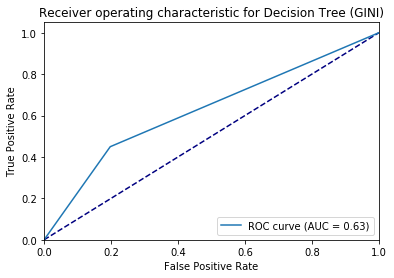

In [40]:
auroc = get_roc(tree, y_test, X_test, "Decision Tree (GINI)")

In [41]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      6741
           1       0.40      0.45      0.43      2008

    accuracy                           0.72      8749
   macro avg       0.62      0.63      0.62      8749
weighted avg       0.73      0.72      0.73      8749



Alternatively, we can use entropy as a measure of heterogeneity. Entropy as a measure of heterogeneity is given by:
![image.png](http://www.sciencealert.com/images/15_.jpg)

In [42]:
tree2 = DecisionTreeClassifier(criterion = "entropy")
tree2.fit(X_train, y_train)
confusion(y_test, tree2.predict(X_test), "Decision Tree (Entropy)")

Of 2008 Defaulters, the Decision Tree (Entropy) identified 865


Predicted,0,1
Actual,,
0,5508,1233
1,1143,865


Optimal Threshold: 1.0


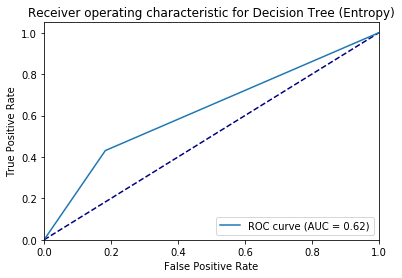

0.6239677471688679

In [43]:
get_roc(tree2, y_test, X_test, "Decision Tree (Entropy)")

In [44]:
print(classification_report(y_test, tree2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      6741
           1       0.41      0.43      0.42      2008

    accuracy                           0.73      8749
   macro avg       0.62      0.62      0.62      8749
weighted avg       0.73      0.73      0.73      8749



There is negligible difference in using GINI or Entropy for decision trees. For the sake of simplicity, we will use GINI for the ensemble methods.

In [45]:
evaluation.loc[0] = (["Decision Tree (GINI)" , 
                      classification_report(y_test, tree.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])

### Random Forest Classifier

#### Theory
Random Forest is an ensemble method for the decision tree algorithm. It works by randomly choosing different features and data points to train multiple trees (that is, to form a forest) - and the resulting prediction is decided by the votes from all the trees. 

Decision Trees are prone to overfitting on the training data, which reduces the performance on the test set. Random Forest mitigates this by training multiple trees. Random Forest is a form of bagging ensemble where the trees are trained concurrently. 

#### Training
To keep things consistent, our Random Forest classifier will also use the GINI Coefficient.



In [46]:
from sklearn.ensemble import RandomForestClassifier
randf = RandomForestClassifier(n_estimators=200)

In [47]:
randf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
print(classification_report(y_train, randf.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13463
           1       1.00      1.00      1.00      4033

    accuracy                           1.00     17496
   macro avg       1.00      1.00      1.00     17496
weighted avg       1.00      1.00      1.00     17496



The training set has also been 100% correctly classified by the random forest model. Evaluating with the test set:

In [49]:
confusion(y_test, randf.predict(X_test), "Decision Tree (Random Forest)")

Of 2008 Defaulters, the Decision Tree (Random Forest) identified 788


Predicted,0,1
Actual,,
0,6265,476
1,1220,788


Optimal Threshold: 0.325


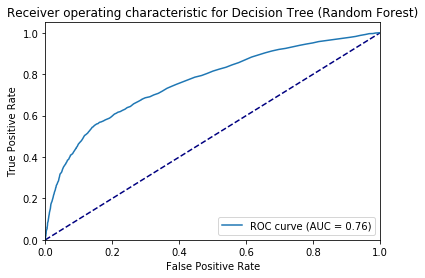

In [50]:
auroc = get_roc(randf, y_test, X_test, "Decision Tree (Random Forest)")

In [51]:
print(classification_report(y_test, randf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      6741
           1       0.62      0.39      0.48      2008

    accuracy                           0.81      8749
   macro avg       0.73      0.66      0.68      8749
weighted avg       0.79      0.81      0.79      8749



In [52]:
evaluation.loc[1] = (["Random Forest" , 
                      classification_report(y_test, randf.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])

The random forest ensemble performs much better than the decision tree alone. The accuracy and AUROC are both superior to the decision tree alone.

### Gradient Boosted Trees Classifier

#### Theory
In this part we train a gradient boosted trees classifier. It is a boosting ensemble method for decision trees, which means that the trees are trained consecutively, where each new tree added is trained to correct the error from the previous tree.
 
#### Training
For consistency our xgBoost ensemble will use n_estimators = 300 as we have done for the random forest ensemble.

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
xgb = GradientBoostingClassifier(n_estimators=300, max_depth = 4)
xgb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [54]:
print(classification_report(y_train, xgb.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     13463
           1       0.79      0.47      0.59      4033

    accuracy                           0.85     17496
   macro avg       0.82      0.72      0.75     17496
weighted avg       0.84      0.85      0.83     17496



We observe that the ensemble did not fully separate the data in the training set. (The default maximum depth is 3, so that might be a factor). Evaluating on the test set,

In [55]:
confusion(y_test, xgb.predict(X_test), "Decision Tree (Gradient Boosted Trees)")

Of 2008 Defaulters, the Decision Tree (Gradient Boosted Trees) identified 796


Predicted,0,1
Actual,,
0,6281,460
1,1212,796


Optimal Threshold: 0.22481097140826298


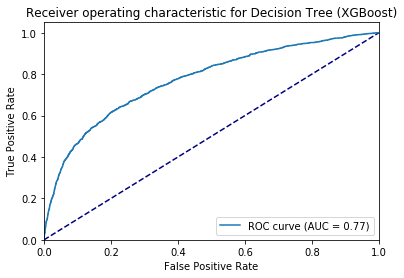

In [56]:
auroc = get_roc(xgb, y_test, X_test, "Decision Tree (XGBoost)")

In [57]:
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      6741
           1       0.63      0.40      0.49      2008

    accuracy                           0.81      8749
   macro avg       0.74      0.66      0.69      8749
weighted avg       0.79      0.81      0.79      8749



In [58]:
evaluation.loc[2] = (["Gradient Boosted" , 
                      classification_report(y_test, xgb.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])

From the accuracy and AUROC, we observe that the gradient boosted tree performs similarly to the random forest ensemble. 

In [59]:
evaluation

,Model,Recall-1,AUROC
0,Decision Tree (GINI),0.449203,0.625991
1,Random Forest,0.392430,0.762567
2,Gradient Boosted,0.396414,0.772109


### Logistic Regression

#### Theory
Logistic regression is a regression technnique used to predict binary target variables. It works on the same principles as a linear regression model. 

Our binary target (default vs non-default) can be expressed in terms of odds of defaulting, which is the ratio of the probability of default and probability of non-default. 

In the logistic regression model, we log the odds (log-odds) and equate it to a weighted sum of regressors.

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/4a5e86f014eb1f0744e280eb0d68485cb8c0a6c3)

We then find weights for the regressors that best fits the data. Since the binary target (default or not) follows a bernoulli distribution, each data point has the following probability distribution function:

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/614e0c64d59f0ff2e926deafcb2de6e502394fac)

We would like to update p for each data point such that the log product (joint probability) of the above function for all data points is maximised. In other words, we are maximising the log-likelihood function.

The logistic regression equation produces a "squashed" curve like the one below. We then pick a cutoff value for the y axis to classify a data point as 0 (non-default) or 1 (default).

![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1280px-Logistic-curve.svg.png)


#### Training
We will adopt a top-down approach for training our logistic regression model, i.e. include all regressors first and then remove the most insignificant ones at each iteration to achieve the best fit.

In [60]:
import statsmodels.api as sm

In [61]:
glm = sm.Logit(y_train,X_train).fit()
glm.summary()

Optimization terminated successfully.
         Current function value: 0.440644
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                17496
Model:                          Logit   Df Residuals:                    17452
Method:                           MLE   Df Model:                           43
Date:                Thu, 21 Nov 2019   Pseudo R-squ.:                  0.1838
Time:                        00:20:46   Log-Likelihood:                -7709.5
converged:                       True   LL-Null:                       -9445.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
LIMIT_BAL                 -0.8518      0.115     -7.395      0.000      -1.078      -0.626
SEX                       -0.1133      0.041     -2.743      0.006      -0.194      -0.032
AGE                        0.1139      0.101      1.131      0.258      -0.084       0.311
PAY_0                      0.6280      0.060     10.471      0.000       0.510       0.746
PAY_2                     -0.4827      0.097     -4.954      0.000      -0.674      -0.292
PAY_3                     -0.2082      0.129     -1.610      0.107      -0.462       0.045
PAY_4                     -0.1967      0.168     -1.168      0.243      -0.527       0.133
PAY_5                      0.0009      0.178      0.005      0.996      -0.347       0.349
PAY_6                      0.3822      0.141      2.704      0.007       0.105       0.659
BILL_AMT1                 -1.4295      0.560     -2.555      0.011      -2.526      -0.333
BILL_AMT2                  1.2398      0.794      1.562      0.118      -0.316       2.795
BILL_AMT3                  1.3438      0.724      1.856      0.063      -0.075       2.763
BILL_AMT4                  0.1902      0.714      0.266      0.790      -1.209       1.590
BILL_AMT5                 -1.0799      0.893     -1.210      0.226      -2.829       0.670
BILL_AMT6                  0.5115      0.810      0.632      0.528      -1.075       2.098
PAY_AMT1                  -1.3273      0.313     -4.238      0.000      -1.941      -0.713
PAY_AMT2                  -1.9003      0.395     -4.807      0.000      -2.675      -1.126
PAY_AMT3                  -0.7195      0.303     -2.371      0.018      -1.314      -0.125
PAY_AMT4                  -0.1019      0.283     -0.361      0.718      -0.656       0.452
PAY_AMT5                  -0.9443      0.290     -3.259      0.001      -1.512      -0.376
PAY_AMT6                  -0.6896      0.265     -2.599      0.009      -1.210      -0.170
GRAD                       1.2393      0.222      5.578      0.000       0.804       1.675
UNI                        1.2243      0.221      5.543      0.000       0.791       1.657
HS                         1.1995      0.225      5.337      0.000       0.759       1.640
MARRIED                    0.1146      0.161      0.711      0.477      -0.201       0.431
SINGLE                    -0.0347      0.162     -0.214      0.830      -0.352       0.283
PAY_0_No_Transactions     -0.0118      0.125     -0.094      0.925      -0.258       0.234
PAY_0_Pay_Duly             0.1005      0.122      0.826      0.409      -0.138       0.339
PAY_0_Revolving_Credit    -0.9197      0.138     -6.665      0.000      -1.190      -0.649
PAY_2_No_Transactions     -1.4280      0.236     -6.041      0.000      -1.891      -0.965
PAY_2_Pay_Duly            -1.2864      0.223     -5.756      0.000      -1.724      -0.848
PAY_2_Revolving_Credit    -0.6996      0.228     -3.071      0.002      -1.146      -0.253
PAY_3_No_Transactions     -0.8235      0.306     -2.694 

In [62]:
print(classification_report(y_train,list(glm.predict(X_train)>0.5)))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     13463
           1       0.68      0.37      0.48      4033

    accuracy                           0.82     17496
   macro avg       0.76      0.66      0.69     17496
weighted avg       0.80      0.82      0.79     17496



The logisitc model with all features performs quite well on both the train and test set with an accuracy of about 0.8. We will now try removing all the insignificant features to see how that affects the model performance.

In [63]:
#remove the most insignificant attribute, and retrain
train_log =  X_train.copy()
glm = sm.Logit(y_train,train_log).fit()
while max(glm.pvalues) > 0.01:
    least =  glm.pvalues[glm.pvalues == max(glm.pvalues)].index[0]
    train_log = train_log.drop(least,axis = 1)
    glm = sm.Logit(y_train,train_log).fit()
glm.summary()   

Optimization terminated successfully.
         Current function value: 0.440644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440647
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440653
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440734
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440782
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                17496
Model:                          Logit   Df Residuals:                    17467
Method:                           MLE   Df Model:                           28
Date:                Thu, 21 Nov 2019   Pseudo R-squ.:                  0.1826
Time:                        00:20:46   Log-Likelihood:                -7721.4
converged:                       True   LL-Null:                       -9445.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
LIMIT_BAL                 -0.8831      0.114     -7.764      0.000      -1.106      -0.660
SEX                       -0.1171      0.041     -2.875      0.004      -0.197      -0.037
PAY_0                      0.5934      0.038     15.655      0.000       0.519       0.668
PAY_2                     -0.4504      0.091     -4.946      0.000      -0.629      -0.272
PAY_3                     -0.2507      0.086     -2.912      0.004      -0.419      -0.082
PAY_6                      0.2312      0.031      7.431      0.000       0.170       0.292
BILL_AMT3                  0.7006      0.186      3.762      0.000       0.336       1.066
PAY_AMT1                  -1.2024      0.294     -4.097      0.000      -1.778      -0.627
PAY_AMT2                  -1.9469      0.379     -5.138      0.000      -2.690      -1.204
PAY_AMT3                  -0.7334      0.280     -2.621      0.009      -1.282      -0.185
PAY_AMT5                  -0.9177      0.262     -3.499      0.000      -1.432      -0.404
PAY_AMT6                  -0.7636      0.264     -2.891      0.004      -1.281      -0.246
GRAD                       1.3330      0.184      7.262      0.000       0.973       1.693
UNI                        1.3192      0.182      7.230      0.000       0.962       1.677
HS                         1.3082      0.186      7.019      0.000       0.943       1.673
MARRIED                    0.1747      0.042      4.148      0.000       0.092       0.257
PAY_0_Revolving_Credit    -1.0207      0.093    -10.950      0.000      -1.203      -0.838
PAY_2_No_Transactions     -1.3481      0.221     -6.091      0.000      -1.782      -0.914
PAY_2_Pay_Duly            -1.1818      0.205     -5.766      0.000      -1.584      -0.780
PAY_2_Revolving_Credit    -0.6119      0.207     -2.959      0.003      -1.017      -0.207
PAY_3_No_Transactions     -0.9409      0.234     -4.021      0.000      -1.400      -0.482
PAY_3_Pay_Duly            -0.8320      0.202     -4.123      0.000      -1.227      -0.436
PAY_3_Revolving_Credit    -0.8628      0.188     -4.599      0.000      -1.230      -0.495
PAY_4_No_Transactions     -0.4574      0.145     -3.161      0.002      -0.741      -0.174
PAY_4_Pay_Duly            -0.4684      0.114     -4.105      0.000      -0.692      -0.245
PAY_4_Revolving_Credit    -0.4575      0.076     -6.025      0.000      -0.606      -0.309
PAY_5_Pay_Duly            -0.2341      0.085     -2.752      0.006      -0.401      -0.067
PAY_6_No_Transactions      0.3031      0.092      3.308      0.001       0.124       0.483
PAY_6_Pay_Duly             0.2868      0.086      3.350      0.001       0.119       0.455
==========================================================================================
"""

In [64]:
count = len(glm.pvalues.index)
print(str(count) + " Columns left:")
print(glm.pvalues.index)

29 Columns left:
Index(['LIMIT_BAL', 'SEX', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_6', 'BILL_AMT3',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT5', 'PAY_AMT6', 'GRAD',
       'UNI', 'HS', 'MARRIED', 'PAY_0_Revolving_Credit',
       'PAY_2_No_Transactions', 'PAY_2_Pay_Duly', 'PAY_2_Revolving_Credit',
       'PAY_3_No_Transactions', 'PAY_3_Pay_Duly', 'PAY_3_Revolving_Credit',
       'PAY_4_No_Transactions', 'PAY_4_Pay_Duly', 'PAY_4_Revolving_Credit',
       'PAY_5_Pay_Duly', 'PAY_6_No_Transactions', 'PAY_6_Pay_Duly'],
      dtype='object')


In [65]:
print(classification_report(y_test,list(glm.predict(X_test[glm.pvalues.index])>0.5)))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      6741
           1       0.64      0.38      0.47      2008

    accuracy                           0.81      8749
   macro avg       0.74      0.66      0.68      8749
weighted avg       0.79      0.81      0.79      8749



Since there is not much change to the model performance on both the train and test set when we reduce the features, we will use the reduced logistic regression model from this point onwards (Principle of Parsimony). 

We now Calculate the AUROC for the train set.

Optimal Threshold: 0.22999391096950886


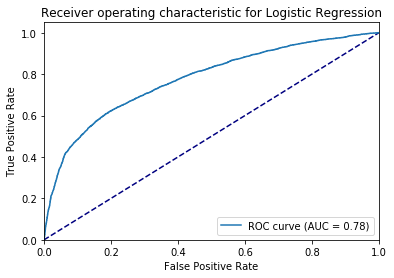

0.7757068306651365

In [66]:
optimal_log = get_optimal(glm, y_train, X_train[glm.pvalues.index], "Logistic Regression")
get_roc(glm, y_train, X_train[glm.pvalues.index], "Logistic Regression")

Since the optimal cut off was found to be ~0.22 using the training data, we will use that as our cut off for our evaluation of the test set.

In [67]:
print(classification_report(y_test,list(glm.predict(X_test[glm.pvalues.index])> optimal_log)))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      6741
           1       0.47      0.60      0.53      2008

    accuracy                           0.75      8749
   macro avg       0.67      0.70      0.68      8749
weighted avg       0.78      0.75      0.76      8749



Unfortunately, the training accuracy has gone down when we used the optimal cutoff. However, accuracy may be misleading in a dataset like ours where most of the targets are non-defaults. 

The recall here is more important - detecting defaulters is more useful than detecting non-defaulters. With a higher recall, our model with lower cutoff is able to correctly catch more defaulters.


Calculate the confusion matrices for both cut offs to better compare their performance.

In [68]:
confusion(y_test,glm.predict(X_test[glm.pvalues.index])>optimal_log, "Logistic Regression")

Of 2008 Defaulters, the Logistic Regression identified 1207


Predicted,False,True
Actual,,
0,5388,1353
1,801,1207


In [69]:
confusion(y_test,glm.predict(X_test[glm.pvalues.index])>0.50, "Logistic Regression")

Of 2008 Defaulters, the Logistic Regression identified 755


Predicted,False,True
Actual,,
0,6321,420
1,1253,755


It is evident that the lower cutoff is better able to detect defualts.

In [70]:
optimal = 
auroc = get_roc(glm, y_test, X_test[glm.pvalues.index], "Logistic Regression")

SyntaxError: invalid syntax (<ipython-input-70-97e902770894>, line 1)

In [71]:
evaluation.loc[3] = ["Logistic Regression" , 
                     classification_report(y_test,list(glm.predict(X_test[glm.pvalues.index])> optimal_log), output_dict = True)["1"]["recall"],
                     auroc]

### Support Vector Machine
#### Theory
Support vector machines attempt to find an optimal hyperplane that is able to separate the two classes in n-dimensional space. This is done by finding the hyperplane that maximises the distance between itself and support vectors (data points that lie closest to the decision boundary).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/617px-SVM_margin.png" width="340" height="340" align="center"/> 

Given a training dataset of form (X,Y), where X is a vector of attributes of the sample, and where Y are either 1 or -1, each indicating the class to which the point X belongs. We want to find the "maximum-margin hyperplane" that divides the group of points X which Y = 1 from the group of points for which Y = -1, which is defined so that the distance between the hyperplane and the nearest point X from either group is maximized.

Any hyperplane can be written as the set of points X satisfying

<table><tr>
<td>
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/90e0fa283c9e642c9c11b22da45efa30b06944a9" width="140" height="140" align="left"/> 
</td>
</tr></table>

where W is the (not necessarily normalized) normal vector to the hyperplane. This is much like Hesse normal form, except that W is not necessarily a unit vector. The parameter b/||W|| determines the offset of the hyperplane from the origin along the normal vector W.

#### Margin
A margin is a separation of line to the closest class points.
Very importrant characteristic of SVM classifier. SVM to core tries to achieve a good margin.
A good margin is one where this separation is larger for both the classes. Images below gives to visual example of good and bad margin. A good margin allows the points to be in their respective classes without crossing to other class.    

<table><tr>
<td> <img src="https://miro.medium.com/max/600/1*Ftns0ebfUHJDdpWt3Wvp-Q.png" width="940" height="940" align="left"//> </td>
<td> <img src="https://miro.medium.com/max/600/1*NbGV1iEtNuklACNUv74w7A.png" width="940" height="940" align="right"/> </td>
</tr></table>

Our goal is to maximize the margin. Among all possible hyperplanes meeting the constraints,  we will choose the hyperplane with the smallest ‖w‖ because it is the one which will have the biggest margin.

##### Hard Margin
If the training data is linearly separable, we can select two parallel hyperplanes that separate the two classes of data, so that the distance between them is as large as possible. The region bounded by these two hyperplanes is called the "margin", and the maximum-margin hyperplane is the hyperplane that lies halfway between them. With a normalized or standardized dataset, these hyperplanes can be described by an equation and we can put this together to get the optimization problem:

 Minimize ||W|| subject to:
<table><tr>   
<td><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/94c99827acb10edd809df63bb86ca1366f01a8ac" width="=240" height="240" align="right"/>
</td>
</tr></table>

##### Soft Margin
Often, the data are not linearly separable. Thus, to extend SVM to cases in which the data are not linearly separable, we introduce the hinge loss function,
<table><tr>   
<td><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f5f7d77f3d46cac51fbac58545aa1a1a183fdf7f" width="=240" height="240" align="right"/>
</td>
</tr></table>

This function is zero if the constraint in (1) is satisfied, in other words, if Xlies on the correct side of the margin. For data on the wrong side of the margin, the function's value is proportional to the distance from the margin.

We then wish to minimize
<table><tr>   
<td><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/579f80b069f186f5a0013b11f90f32833ff8c681" width="=240" height="240" align="right"/>
</td>
</tr></table>

where the parameter lambda determines the trade-off between increasing the margin size and ensuring that the X lie on the correct side of the margin. Thus, for sufficiently small values of lambda , the second term in the loss function will become negligible, hence, it will behave similar to the hard-margin SVM, if the input data are linearly classifiable, but will still learn if a classification rule is viable or not.

#### Computing SVM classifier
We focus on the soft-margin classifier since, as noted above, choosing a sufficiently small value for lambda  yields the hard-margin classifier for linearly classifiable input data. The classical approach, which involves reducing (2) to a quadratic programming problem, is detailed below.

##### Primal
Minimizing (2) can be rewritten as a constrained optimization problem with a differentiable objective function in the following way.

We can rewrite the optimization problem as follows
<table><tr>   
<td><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/71501a21527b0f375eb349fdaf95f33a78b1db6d" width="=240" height="240" align="right"/>
</td>
</tr></table>

This is called the primal problem.

##### Dual
By solving for the Lagrangian dual of the above problem, one obtains the simplified problem
<table><tr>   
<td><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/9c89851fa2fcd9c920aa089a2a8d75784a84d623" width="=240" height="240" align="center"/>
</td>
</tr></table>
<table><tr>   
<td><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/2c83e8ce81ee25becb185682c98ed31c00c67995" width="=240" height="240" align="center"/>
</td>
</tr></table>
This is called the dual problem. Since the dual maximization problem is a quadratic function of the C subject to linear constraints, it is efficiently solvable by quadratic programming algorithms.

Here, the variables C are defined such that
<table><tr>   
<td><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/cf0866d87cbe878e13e6a06560af15b9a9cc6bb0" width="=240" height="240" align="right"/>
</td>
</tr></table>


### Parameter Tuning


#### Kernel
For a dataset that is non-linearly separable, a way is to create nonlinear classifiers by applying the kernel trick to maximum-margin hyperplanes. The resulting algorithm is formally similar, except that every dot product is replaced by a nonlinear kernel function. This allows the algorithm to fit the maximum-margin hyperplane in a transformed feature space. The transformation may be nonlinear and the transformed space high-dimensional; although the classifier is a hyperplane in the transformed feature space, it may be nonlinear in the original input space.

Generally, Linear Kernel is the best choice as SVM is already a linear model and has the lowest computational complexity. More often, if the dataset is not linearly separable, Radial Basis Function is the next most common kernel to be used.

#### Regularization (C value)
The Regularization parameter (often termed as C parameter in python’s sklearn library) tells the SVM optimization how much you want to avoid misclassifying each training example.

For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points.             

<table><tr>
<td> <img src="https://miro.medium.com/max/600/1*1dwut8cWQ-39POHV48tv4w.png" width="940" height="940" align="left"//> </td>
<td> <img src="https://miro.medium.com/max/600/1*gt_dkcA5p0ZTHjIpq1qnLQ.png" width="940" height="940" align="right"/> </td>
</tr></table>
<b>Left: low regularization value, right: high regularization value</b>


The tradeoff is however, a larger value of C might result in overfitting of the model, which is undersirable as it does not generalise the model for other data sets. Consequently, a smaller value of C might result in too many misclassified data points, which means that the model is low in accuracy in the first place. Thus, choosing the right balance of the C value is important.

#### Gamma
The gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. In other words, with low gamma, points far away from plausible separation line are considered in the calculation for the separation line. Where as high gamma means the points close to plausible line are considered in the calculation.          

<table><tr>
<td> <img src="https://miro.medium.com/max/600/1*dGDQxV8j83VB90skHsXktw.png" width="940" height="940" align="left"//> </td>
<td> <img src="https://miro.medium.com/max/600/1*ClmsnU_yb1YtIwAAr7krmg.png" width="940" height="940" align="right"/> </td>
</tr></table>

Similarly to regularization, there is a tradeoff between high and low values of Gamma. Higher values of Gamma may result in too strict rules and thus the model cannot find a linearly separable line. Whereas lower values of Gamma may result in including too much noise into the model by including further away points, which reduces the model accuracy. Thus, finding the right balance of Gamma is also important.

### Apply SVM model
For this dataset, we will perform SVM to the model and access its accuracy progressively, starting from no parameter tuning.

#### SVM without parameter tuning
First, we train our SVM model without parameter tuning. Note that the default kernel for sklearn svm is "rbf" and cost = 1.0 and gamma = 1/n where n is the number of samples.

In [72]:
from sklearn import svm
#train svm model without standardization and no parameter tuning
clf_original = svm.SVC( probability = True, gamma = 'scale')
clf_original.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Optimal Threshold: 0.1567076896169202


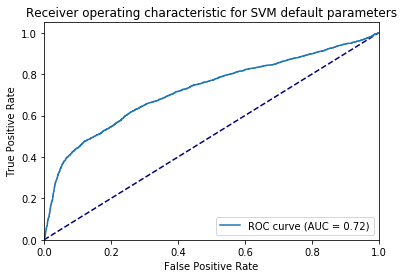

0.7227905615337198

In [73]:
#plot roc for svm
get_roc(clf_original, y_test, X_test, "SVM default parameters")

In [74]:
#confusion matrix
confusion(y_test,clf_original.predict(X_test), "SVM default parameters")

Of 2008 Defaulters, the SVM default parameters identified 768


Predicted,0,1
Actual,,
0,6321,420
1,1240,768


In [75]:
print(classification_report(y_test, clf_original.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.94      0.88      6741
           1       0.65      0.38      0.48      2008

    accuracy                           0.81      8749
   macro avg       0.74      0.66      0.68      8749
weighted avg       0.79      0.81      0.79      8749



Based on AUROC and Recall, the SVM model with default parameters seem to do average compared to the other models tested. Now let's search for the best parameters to tune the model.

#### SVM with Parameter tuning
One way to find the best parameters for the model is using grid search via GridSearchCV package from sklearn. 

Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model. This is significant as the performance of the entire model is based on the hyper parameter values specified.

GridSearchSV works by using a cross validation process to determine the hyper parameter value set which provides the best accuracy levels. We will start with the linear kernel and move on to rbf if necessary.

In [ ]:
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.01, 0.1, 1]
    gammas = [0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds, scoring = 'recall')
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_
svc_param_selection(X_train, y_train,2)


With 5 folds, it can be found that C = 0.01 , and gamma = 0.01 will have the best svm model with  kernel

In [76]:
#train svm model with feature reduction and cost = 0.01, gamma = 0.01, linear kernel
clf_reduced_tuned = svm.SVC(kernel = 'linear', probability = True, C = 0.01, gamma = 0.01 )
clf_reduced_tuned.fit(X_train, y_train)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Optimal Threshold: 0.15368680599405346


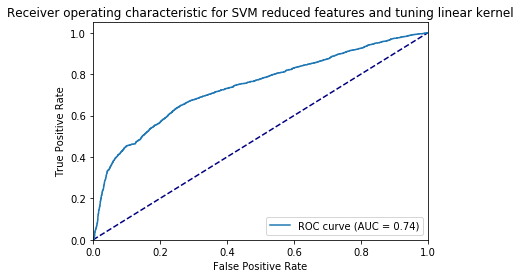

In [77]:
auroc = get_roc(clf_reduced_tuned, y_test, X_test, 
        "SVM reduced features and tuning linear kernel")

In [78]:
#confusion matrix
confusion(y_test,clf_reduced_tuned.predict(X_test), "SVM reduced features and tuning linear kernal")

Of 2008 Defaulters, the SVM reduced features and tuning linear kernal identified 696


Predicted,0,1
Actual,,
0,6405,336
1,1312,696


In [79]:
print(classification_report(y_test, clf_reduced_tuned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6741
           1       0.67      0.35      0.46      2008

    accuracy                           0.81      8749
   macro avg       0.75      0.65      0.67      8749
weighted avg       0.79      0.81      0.79      8749



As shown, the AUROC actually increased with tuning of parameters. Next, we will experiment with the RBF kernel

In [80]:
#train svm model with feature reduction and cost = 0.1, gamma = 0.1, rbf kernel
clf_reduced_tuned_rbf = svm.SVC(kernel = 'rbf', probability = True, C = 0.1, gamma = 0.1)
clf_reduced_tuned_rbf.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Optimal Threshold: 0.15780782271279034


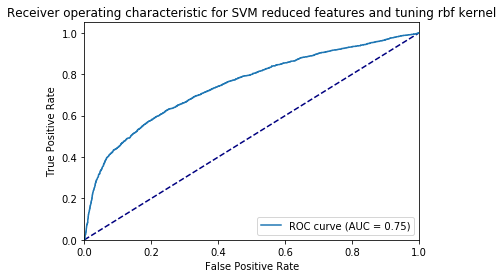

In [81]:
auroc = get_roc(clf_reduced_tuned_rbf, y_test, X_test, 
        "SVM reduced features and tuning rbf kernel")

In [82]:
print(classification_report(y_test, clf_reduced_tuned_rbf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      6741
           1       0.64      0.40      0.49      2008

    accuracy                           0.81      8749
   macro avg       0.74      0.67      0.69      8749
weighted avg       0.79      0.81      0.79      8749



As shown, the rbf kernel increases the AUROC and the recall increased to 0.40, thus, it can be said that the rbf kernel is better than the linear kernel.

#### SVM with filtered features

We will now apply the best selected kernel (linear kernel) on filtered features to access AUROC and recall.

In [86]:
clf_reduced_tuned_filtered = svm.SVC(kernel = 'rbf', probability = True)
clf_reduced_tuned_filtered.fit(X_train_filter, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Optimal Threshold: 0.15729612279514055


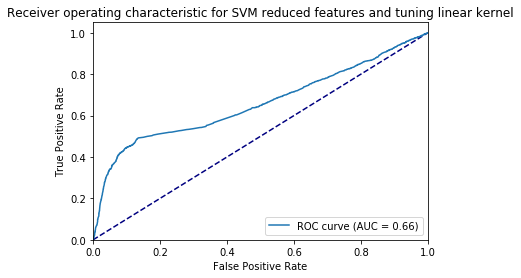

In [87]:
auroc = get_roc(clf_reduced_tuned_filtered, y_test, X_test_filter, 
        "SVM reduced features and tuning linear kernel")

In [88]:
print(classification_report(y_test, clf_reduced_tuned_filtered.predict(X_test_filter)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      6741
           1       0.62      0.40      0.49      2008

    accuracy                           0.81      8749
   macro avg       0.73      0.66      0.68      8749
weighted avg       0.79      0.81      0.79      8749



As we can see, the performance is not as great after using filtered features. The AUROC decreased while the recall remained the same. Thus, we will use unfiltered features and SVM with rbf kernel.

### Neural Networks
We will now use the train and test sets as defined above and attempt to implement a neural network model on the data

#### Theory
A neural network is comprised of many layers of perceptrons that take in a vector as input and outputs a value. The outputs from one layer of perceptrons are passed into the next layer of perceptrons as input, until we reach the output layer. Each perceptron combines its input via an activation function. 

.


![image.png](https://www.researchgate.net/profile/Leslaw_Plonka/publication/260080460/figure/fig1/AS:340931325775876@1458295770470/A-simple-neural-network-diagram.png)


The network is at first randomly initialised with random weights on all its layers. Training samples are then passed into the network and predictions are made. The training error (difference between the actual value and the predicted value) is used to recalibrate the neural network by changing the weights. The change in weights is found via gradient descent, and  then backpropogated through the neural network to update all layers.


This process is repeated iteratively until the model converges (i.e. it cannot be improved further).

#### Training
Here we create an instance of our model, with 5 layers of 26 neurons each, identical to that of our training data. 

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(26,26,26,26,26), activation = "logistic")

In [ ]:
mlp.fit(X_train,y_train)

In [ ]:
predictions = mlp.predict(X_test)

In [ ]:
confusion(y_test,predictions,"Neural Network (5x26)")

In [ ]:
auroc = get_roc(mlp, y_test, X_test, "Neural Network (5x26)")

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
evaluation.loc[5] = (["Neural Network" , 
                      classification_report(y_test, mlp.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])

evaluation

### Deep Learning

#### Theory



In [ ]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=44, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=20, batch_size=10)


In [ ]:
# evaluate the keras model
#recall, accuracy = model.evaluate(df1, target)
#print('Accuracy: %.2f' % (accuracy*100))
#print('Recall: %.2f' % (recall*100))

predictions = list(model.predict(X_test).ravel() > 0.5)
#confusion(y_test, model.predict(X_test[sig.index]), "Deep Learning Keras Model")
auroc = get_roc(model, y_test, X_test, "Deep Learning Keras Model")

print(classification_report(y_test,predictions))

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=10)
predictions = list(model.predict(X_test).ravel() > 0.5)
#confusion(y_test, model.predict(X_test[sig.index]), "Deep Learning Keras Model")
auroc = get_roc(model, y_test, X_test, "Deep Learning Keras Model")

print(classification_report(y_test,predictions))

### Adam optimizer

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=20)
predictions = list(model.predict(X_test).ravel() > 0.5)
#confusion(y_test, model.predict(X_test[sig.index]), "Deep Learning Keras Model")
auroc = get_roc(model, y_test, X_test, "Deep Learning Keras Model")

print(classification_report(y_test,predictions))

### Adam optimizer

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=44, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)
predictions = list(model.predict(X_test).ravel() > 0.5)
#confusion(y_test, model.predict(X_test[sig.index]), "Deep Learning Keras Model")
auroc = get_roc(model, y_test, X_test, "Deep Learning Keras Model")

print(classification_report(y_test,predictions))

### Adamax Optimizer

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=44, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)
predictions = list(model.predict(X_test).ravel() > 0.5)
#confusion(y_test, model.predict(X_test[sig.index]), "Deep Learning Keras Model")
auroc = get_roc(model, y_test, X_test, "Deep Learning Keras Model")

print(classification_report(y_test,predictions))

### Adadelta Optimizer

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=44, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)
predictions = list(model.predict(X_test).ravel() > 0.5)
#confusion(y_test, model.predict(X_test[sig.index]), "Deep Learning Keras Model")
auroc = get_roc(model, y_test, X_test, "Deep Learning Keras Model")

print(classification_report(y_test,predictions))

### Adagrad Optimzier

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=17, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)
predictions = list(model.predict(X_test).ravel() > 0.5)
#confusion(y_test, model.predict(X_test[sig.index]), "Deep Learning Keras Model")
auroc = get_roc(model, y_test, X_test, "Deep Learning Keras Model")

print(classification_report(y_test,predictions))

evaluation.loc[6] = (["Deep Learning Neural Network with Keras" , 
                      classification_report(y_test, mlp.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])

evaluation

### RMSProp

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=44, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)
predictions = list(model.predict(X_test).ravel() > 0.5)
#confusion(y_test, model.predict(X_test[sig.index]), "Deep Learning Keras Model")
auroc = get_roc(model, y_test, X_test, "Deep Learning Keras Model")

print(classification_report(y_test,predictions))

### SGD

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=44, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)
predictions = list(model.predict(X_test).ravel() > 0.5)
#confusion(y_test, model.predict(X_test[sig.index]), "Deep Learning Keras Model")
auroc = get_roc(model, y_test, X_test, "Deep Learning Keras Model")

print(classification_report(y_test,predictions))

### Adam

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=44, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)
predictions = list(model.predict(X_test).ravel() > 0.5)
#confusion(y_test, model.predict(X_test[sig.index]), "Deep Learning Keras Model")
auroc = get_roc(model, y_test, X_test, "Deep Learning Keras Model")

print(classification_report(y_test,predictions))

### conclude that best optimizer is adagrad, so now we use filtered data to run tests

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=17, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train_filter, y_train, epochs=10, batch_size=10)
predictions = list(model.predict(X_test_filter).ravel() > 0.5)
#confusion(y_test, model.predict(X_test[sig.index]), "Deep Learning Keras Model")
auroc = get_roc(model, y_test, X_test_filter, "Deep Learning Keras Model")

print(classification_report(y_test,predictions))

evaluation.loc[6] = (["Deep Learning Neural Network with Keras" , 
                      classification_report(y_test, mlp.predict(X_test_filter), output_dict = True)["1"]["recall"],
                      auroc])

evaluation

### Naive Bayes
#### Theory
Naive Bayes classifier is a probabilistic machine learning model used for classification. The crux of the classifier is based on the Bayes theorem.
##### Bayes Theorem:
![image.png](https://miro.medium.com/max/510/1*tjcmj9cDQ-rHXAtxCu5bRQ.png)
Using the Bayes theorem, we can find the probability of A happening, given that B has occured.
One assumption about naive bayes is that the predictors/features are independent.

#### Training the Naive bayes model

In [ ]:
from sklearn import datasets
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

gnb = GaussianNB()

In [ ]:
#training naive bayes model
gnb.fit(X_train, y_train)

In [ ]:
#classifying values
predicted = gnb.predict(X_train)
expected = y_train

In [ ]:
#plot roc for naive Bayes
get_roc(gnb, y_test, X_test, "Naive Bayes")

In [ ]:
#accessing model performance
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))